# Import Libraries

In [91]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.rcParams["figure.figsize"] = (10, 6)

import re
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import SCORERS
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
def train_val(y_train, y_train_pred, y_test, y_pred, i):
    
    scores = {i+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    i+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

# Read Dataset

In [3]:
df = pd.read_csv("co2.csv")
df.head()

Make       Model Vehicle Class  Engine Size(L)  Cylinders Transmission   
0  ACURA         ILX       COMPACT             2.0          4          AS5  \
1  ACURA         ILX       COMPACT             2.4          4           M6   
2  ACURA  ILX HYBRID       COMPACT             1.5          4          AV7   
3  ACURA     MDX 4WD   SUV - SMALL             3.5          6          AS6   
4  ACURA     RDX AWD   SUV - SMALL             3.5          6          AS6   

  Fuel Type  Fuel Consumption City (L/100 km)   
0         Z                               9.9  \
1         Z                              11.2   
2         Z                               6.0   
3         Z                              12.7   
4         Z                              12.1   

   Fuel Consumption Hwy (L/100 km)  Fuel Consumption Comb (L/100 km)   
0                              6.7                               8.5  \
1                              7.7                               9.6   
2                              5.8                               5.9   
3                              9.1                              11.1   
4                              8.7                              10.6   

   Fuel Consumption Comb (mpg)  CO2 Emissions(g/km)  
0                           33                  196  
1                           29                  221  
2                           48                  136  
3                           25                  255  
4                           27                  244

In [4]:
df.rename(columns ={'Make' : "make",
                    'Model' : "model",
                    'Vehicle Class' :  "vehicle_class",
                    'Engine Size(L)': "engine_size",
                    'Cylinders': "cylinders",
                   'Transmission' : "transmission",
                    'Fuel Type' : "fuel_type",
                    'Fuel Consumption City (L/100 km)' : "fuel_cons_city",
                   'Fuel Consumption Hwy (L/100 km)': "fuel_cons_hwy",
                    'Fuel Consumption Comb (L/100 km)' :"fuel_cons_comb",
                   'Fuel Consumption Comb (mpg)' : "fuel_cons_comb_mpg"
                    , 'CO2 Emissions(g/km)' : "co2"
                   }, inplace = True)

# EDA

In [5]:
df.shape

(7385, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7385 entries, 0 to 7384
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make                7385 non-null   object 
 1   model               7385 non-null   object 
 2   vehicle_class       7385 non-null   object 
 3   engine_size         7385 non-null   float64
 4   cylinders           7385 non-null   int64  
 5   transmission        7385 non-null   object 
 6   fuel_type           7385 non-null   object 
 7   fuel_cons_city      7385 non-null   float64
 8   fuel_cons_hwy       7385 non-null   float64
 9   fuel_cons_comb      7385 non-null   float64
 10  fuel_cons_comb_mpg  7385 non-null   int64  
 11  co2                 7385 non-null   int64  
dtypes: float64(4), int64(3), object(5)
memory usage: 692.5+ KB


In [7]:
df.isna().sum().any()

False

In [8]:
df.describe().T

count        mean        std   min    25%    50%    75%   
engine_size         7385.0    3.160068   1.354170   0.9    2.0    3.0    3.7  \
cylinders           7385.0    5.615030   1.828307   3.0    4.0    6.0    6.0   
fuel_cons_city      7385.0   12.556534   3.500274   4.2   10.1   12.1   14.6   
fuel_cons_hwy       7385.0    9.041706   2.224456   4.0    7.5    8.7   10.2   
fuel_cons_comb      7385.0   10.975071   2.892506   4.1    8.9   10.6   12.6   
fuel_cons_comb_mpg  7385.0   27.481652   7.231879  11.0   22.0   27.0   32.0   
co2                 7385.0  250.584699  58.512679  96.0  208.0  246.0  288.0   

                      max  
engine_size           8.4  
cylinders            16.0  
fuel_cons_city       30.6  
fuel_cons_hwy        20.6  
fuel_cons_comb       26.1  
fuel_cons_comb_mpg   69.0  
co2                 522.0

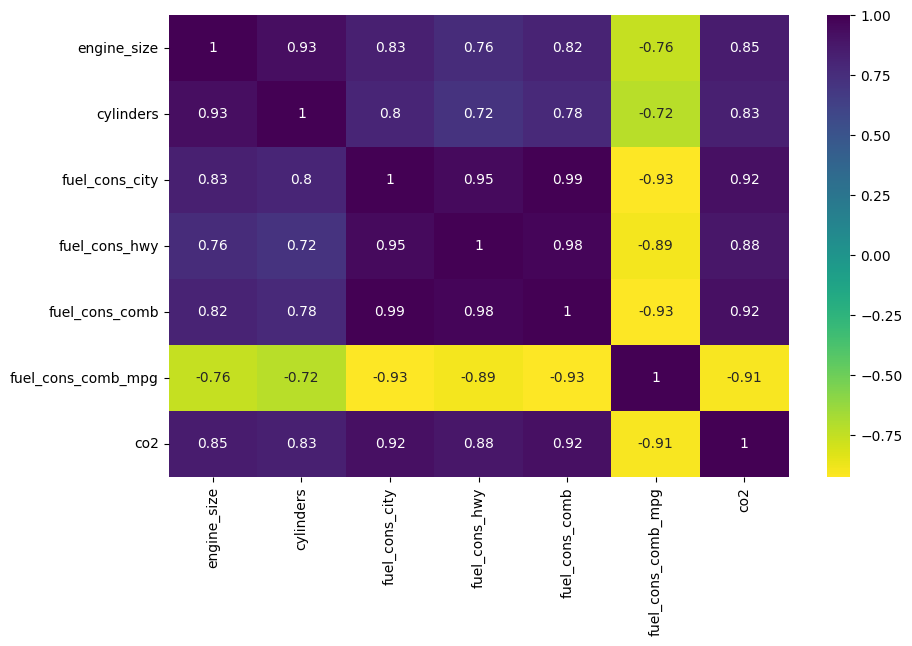

In [9]:
sns.heatmap(df.select_dtypes("number").corr(), annot = True, cmap = "viridis_r");

sns.pairplot(df)
plt.show()

## co2

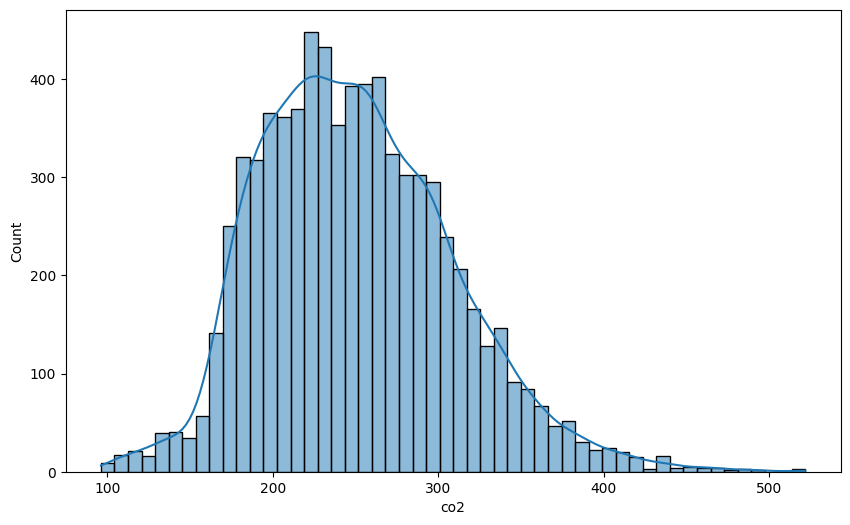

In [10]:
sns.histplot(df.co2, kde = True);

In [11]:
fig = px.box(df, x = "co2", hover_data = ["make"])
fig.show()
# özellikle bugatti outlier olarak göze çarpıyor

In [12]:
statistic, p_value = stats.shapiro(df.co2)
round(p_value, 5)

# shapiro testine göre co2 columns normal dağılıma sahip değil

0.0

In [13]:
stats.skew(df.co2)

# skewness'e göre hafif sağa çarpık normal dağılım gösteriyor

0.5259869435378954

## Make

In [14]:
df.make.value_counts()

make
FORD             628
CHEVROLET        588
BMW              527
MERCEDES-BENZ    419
PORSCHE          376
TOYOTA           330
GMC              328
AUDI             286
NISSAN           259
JEEP             251
DODGE            246
KIA              231
HONDA            214
HYUNDAI          210
MINI             204
VOLKSWAGEN       197
MAZDA            180
LEXUS            178
JAGUAR           160
CADILLAC         158
SUBARU           140
VOLVO            124
INFINITI         108
BUICK            103
RAM               97
LINCOLN           96
MITSUBISHI        95
CHRYSLER          88
LAND ROVER        85
FIAT              73
ACURA             72
MASERATI          61
ROLLS-ROYCE       50
ASTON MARTIN      47
BENTLEY           46
LAMBORGHINI       41
ALFA ROMEO        30
GENESIS           25
SCION             22
SMART              7
BUGATTI            3
SRT                2
Name: count, dtype: int64

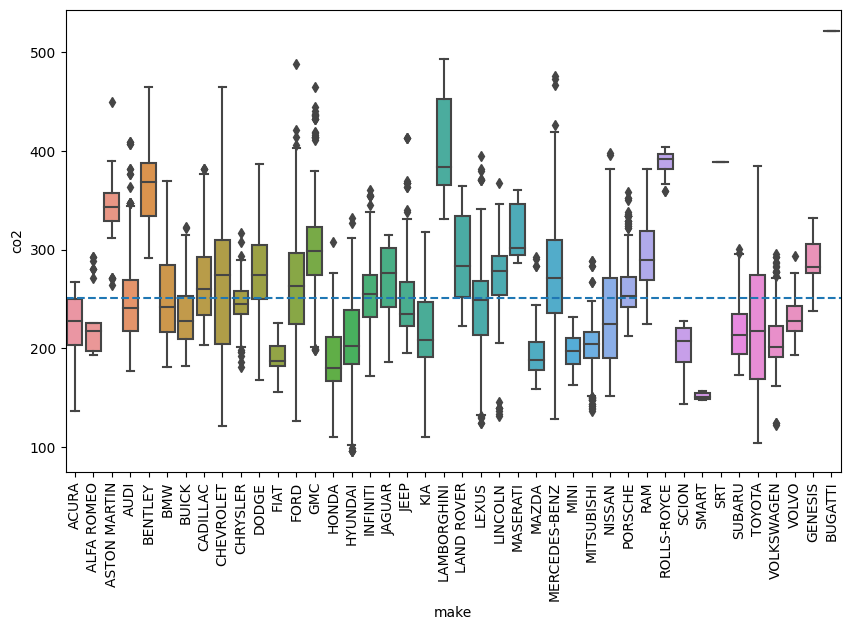

In [15]:
sns.boxplot(data = df, x = "make", y = "co2")
plt.xticks(rotation = 90)
plt.axhline(y = df.co2.mean(), linestyle = "--") 
plt. show()
# bugatti oldukça co2 emisyonuna sahip ve çok az gözlem var
# srt yüksek co2 emisyonuna sahip ve çok az gözlem var
# drop edelim

In [16]:
index_ = df[(df.make == "BUGATTI") | (df.make == "SRT")].index
df.drop(index_, inplace = True)

## Model

In [17]:
df.model.nunique()
# çok fazla model var

2049

In [18]:
df.model.value_counts()

model
F-150 FFV 4X4           32
F-150 FFV               32
MUSTANG                 27
FOCUS FFV               24
SONIC                   20
                        ..
AVENTADOR S ROADSTER     1
HURACAN AWD              1
HURACAN SPYDER AWD       1
LS 500                   1
XC40 T4 AWD              1
Name: count, Length: 2049, dtype: int64

In [19]:
df.model.value_counts(normalize = True)[:20]

model
F-150 FFV 4X4    0.004336
F-150 FFV        0.004336
MUSTANG          0.003659
FOCUS FFV        0.003252
SONIC            0.002710
SONIC 5          0.002710
F-150            0.002710
F-150 4X4        0.002710
TACOMA 4WD       0.002575
ATS              0.002575
ACCORD           0.002575
JETTA            0.002575
COMPASS          0.002575
SILVERADO        0.002439
FORTE 5          0.002439
SIERRA 4WD       0.002439
CAMARO           0.002439
SIERRA           0.002439
COROLLA          0.002439
SILVERADO 4WD    0.002439
Name: proportion, dtype: float64

## Vehicle Class

In [20]:
df.vehicle_class.value_counts()

vehicle_class
SUV - SMALL                 1217
MID-SIZE                    1133
COMPACT                     1022
SUV - STANDARD               735
FULL-SIZE                    639
SUBCOMPACT                   606
PICKUP TRUCK - STANDARD      538
TWO-SEATER                   455
MINICOMPACT                  326
STATION WAGON - SMALL        252
PICKUP TRUCK - SMALL         159
MINIVAN                       80
SPECIAL PURPOSE VEHICLE       77
VAN - PASSENGER               66
STATION WAGON - MID-SIZE      53
VAN - CARGO                   22
Name: count, dtype: int64

In [21]:
fig = px.box(df, x = "co2", hover_data = ["vehicle_class"])
fig.show()

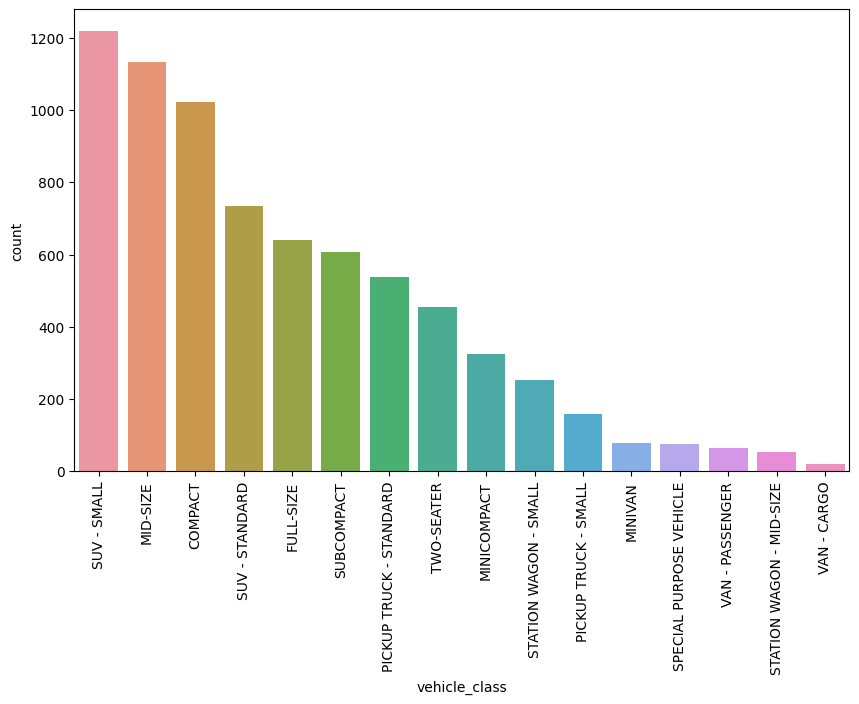

In [22]:
sns.countplot(data = df, x = "vehicle_class", order = df.vehicle_class.value_counts().index)
plt.xticks(rotation = 90)
plt.show()

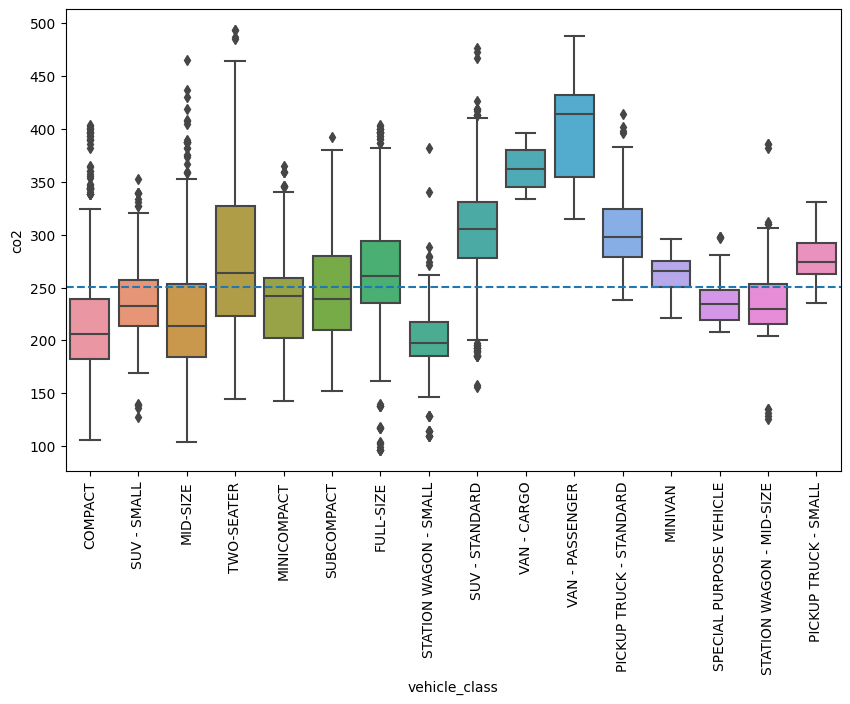

In [23]:
sns.boxplot(data = df, x = "vehicle_class", y = "co2")
plt.xticks(rotation = 90)
plt.axhline(y = df.co2.mean(), linestyle = "--") 
plt. show()

## Engine Size

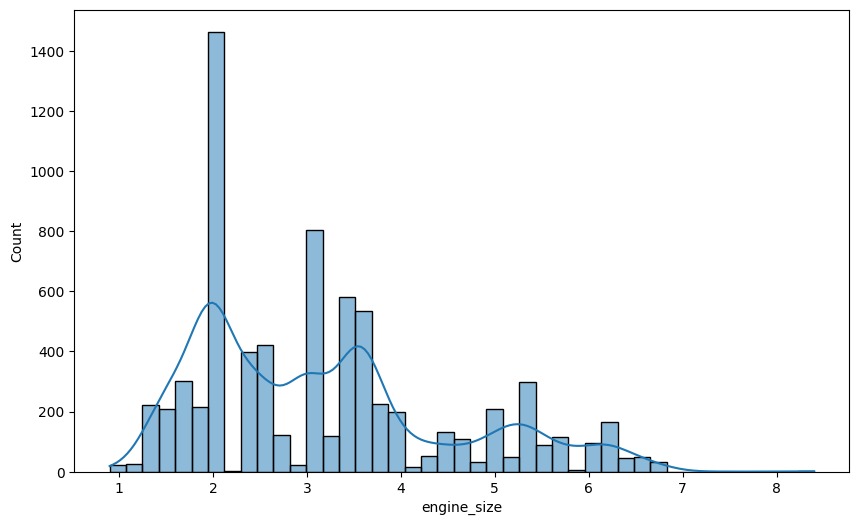

In [24]:
sns.histplot(data = df, x = "engine_size", kde = True)
plt.show()

In [25]:
statistic, p_value = stats.shapiro(df.engine_size)
round(p_value, 5)

0.0

In [26]:
stats.skew(df.engine_size)

0.792921492712887

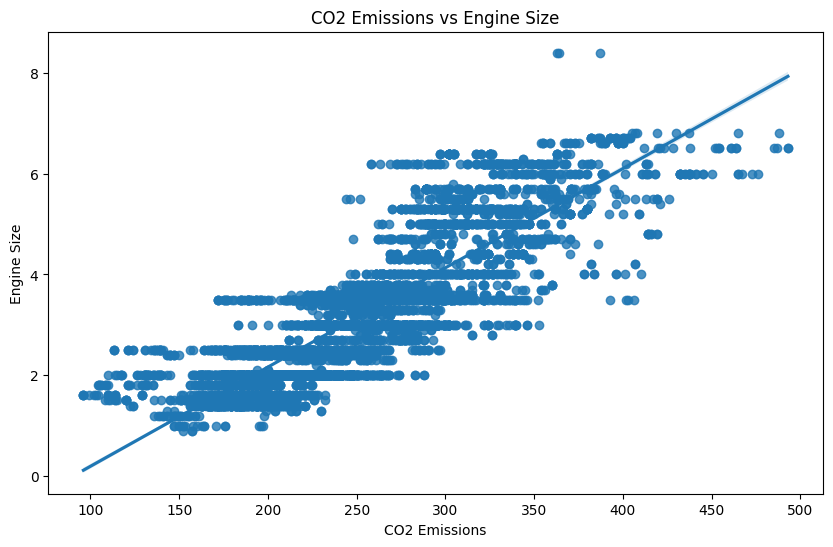

In [27]:
sns.regplot(data = df, x = "co2", y = "engine_size")
plt.xlabel("CO2 Emissions")
plt.ylabel("Engine Size")
plt.title("CO2 Emissions vs Engine Size")
plt.show()

## Cylinders

In [28]:
df.cylinders.value_counts()

cylinders
4     3220
6     2446
8     1402
12     151
3       95
10      40
5       26
Name: count, dtype: int64

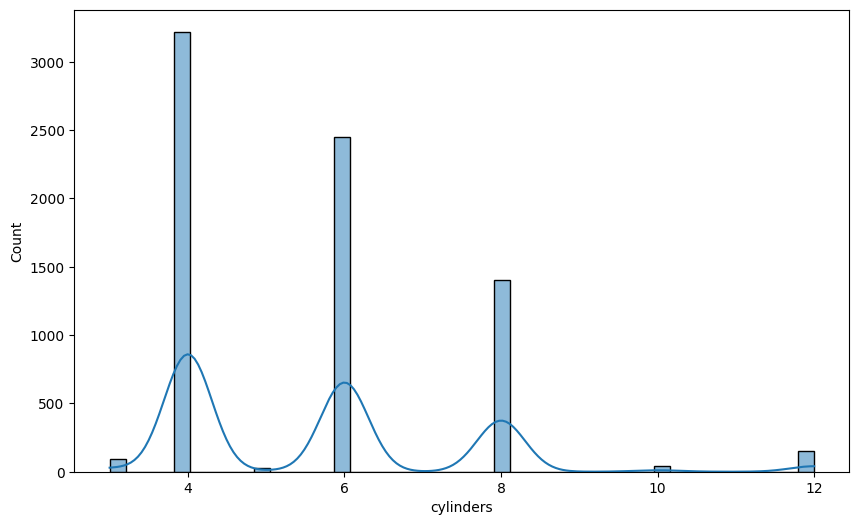

In [29]:
sns.histplot(data = df, x = "cylinders", kde = True)
plt.show()

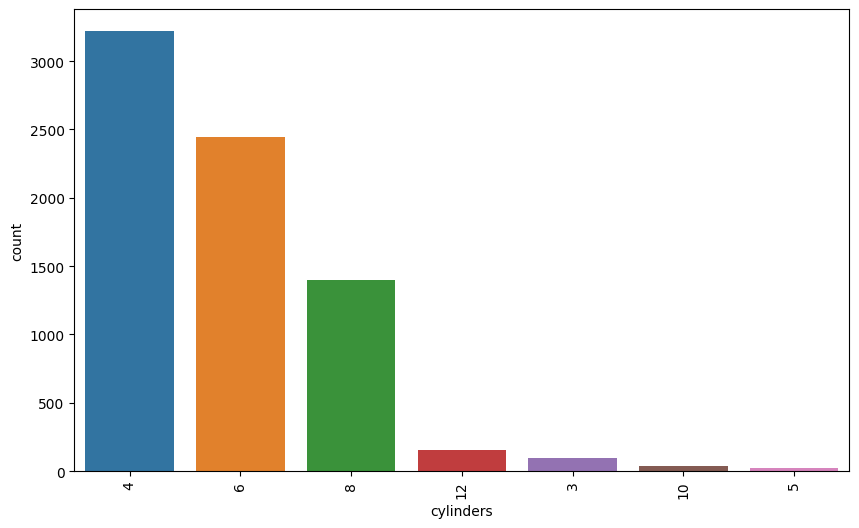

In [30]:
sns.countplot(data = df, x = "cylinders", order = df.cylinders.value_counts().index)
plt.xticks(rotation = 90)
plt.show()

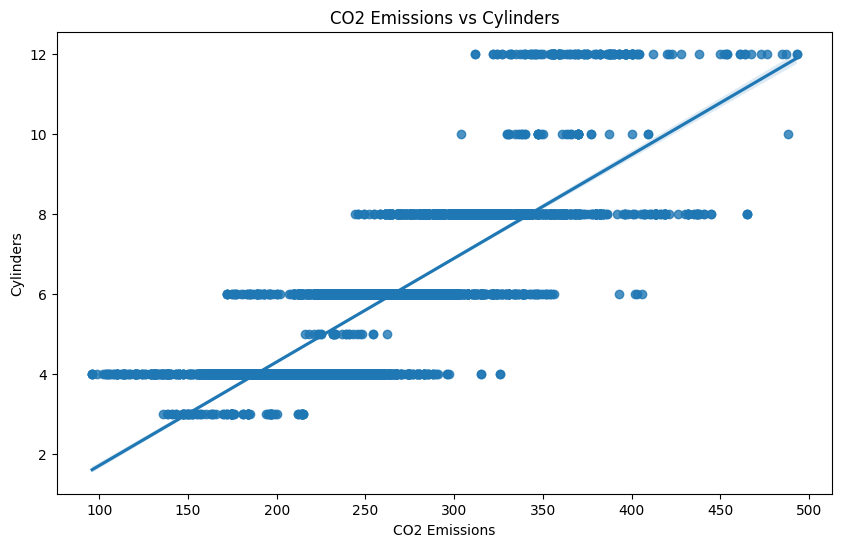

In [31]:
sns.regplot(data = df, x = "co2", y = "cylinders")
plt.xlabel("CO2 Emissions")
plt.ylabel("Cylinders")
plt.title("CO2 Emissions vs Cylinders")
plt.show()

## Transmission	

In [32]:
df.transmission.value_counts()

transmission
AS6     1324
AS8     1211
M6       899
A6       789
A8       490
AM7      442
A9       339
AS7      319
AV       295
M5       193
AS10     168
AM6      132
AV7      118
AV6      113
M7        91
A5        84
AS9       77
A4        65
AM8       62
A7        53
AV8       39
A10       31
AS5       26
AV10      11
AM5        4
AM9        3
AS4        2
Name: count, dtype: int64

In [33]:
df["gears"] = df["transmission"].copy()

df["gears"] = df["gears"].apply(lambda x: re.findall(r"\d+", str(x))[0] if re.findall(r"\d+", str(x)) else "No Gears")

df["transmission"] = df["transmission"].apply(
                    lambda x: re.findall("[A-Za-z]+", str(x))[0] if re.findall("[A-Za-z]+", str(x)) else None)

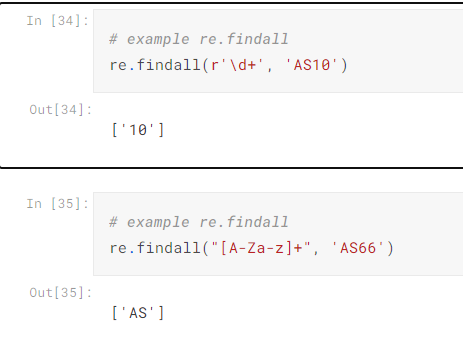

In [34]:
df = df[['make', 'model', 'vehicle_class', 'engine_size', 'cylinders',
       'transmission', 'gears', 'fuel_type', 'fuel_cons_city', 'fuel_cons_hwy',
       'fuel_cons_comb', 'fuel_cons_comb_mpg', 'co2']]
#gears ile transmission sütunlarını yan yana görmek için sütun sırasını tekrar düzenledim
df.sample(5)

make         model   vehicle_class  engine_size  cylinders   
6942    HYUNDAI       Elantra        MID-SIZE          1.6          4  \
7329     TOYOTA       Corolla         COMPACT          1.8          4   
1972     NISSAN     ROGUE AWD     SUV - SMALL          2.5          4   
272   CHEVROLET          TRAX     SUV - SMALL          1.4          4   
5673  CHEVROLET  Suburban 4WD  SUV - STANDARD          5.3          8   

     transmission     gears fuel_type  fuel_cons_city  fuel_cons_hwy   
6942            M         6         X            10.1            7.6  \
7329            M         6         X             8.0            6.0   
1972           AV  No Gears         X             9.5            7.4   
272             M         6         X             9.1            6.8   
5673            A         6         X            16.8           11.3   

      fuel_cons_comb  fuel_cons_comb_mpg  co2  
6942             9.0                  31  214  
7329             7.1                  40  165  
1972             8.5                  33  196  
272              8.1                  35  186  
5673            14.3                  20  336

In [35]:
df.gears.value_counts()

gears
6           3257
8           1802
7           1023
9            419
5            307
No Gears     295
10           210
4             67
Name: count, dtype: int64

In [36]:
df.transmission.value_counts()

transmission
AS    3127
A     1851
M     1183
AM     643
AV     576
Name: count, dtype: int64

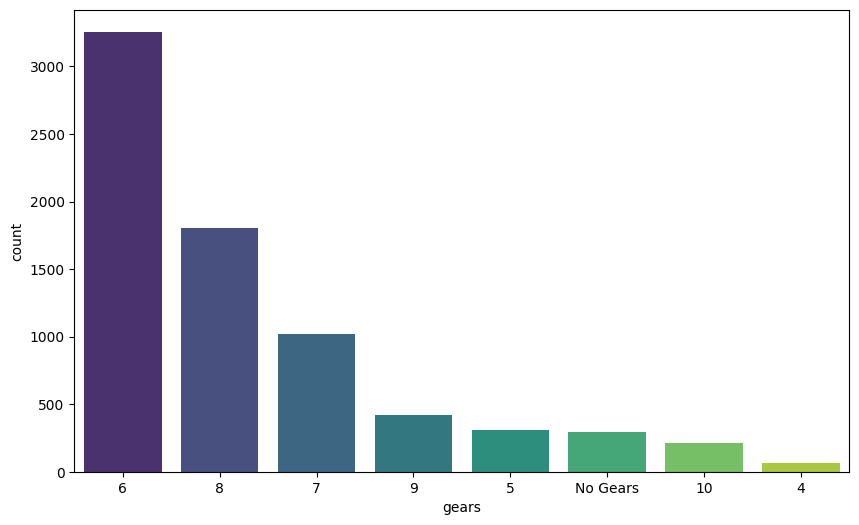

In [37]:
sns.countplot(data = df, x = "gears", palette = "viridis", order = df.gears.value_counts().index)
plt.show()

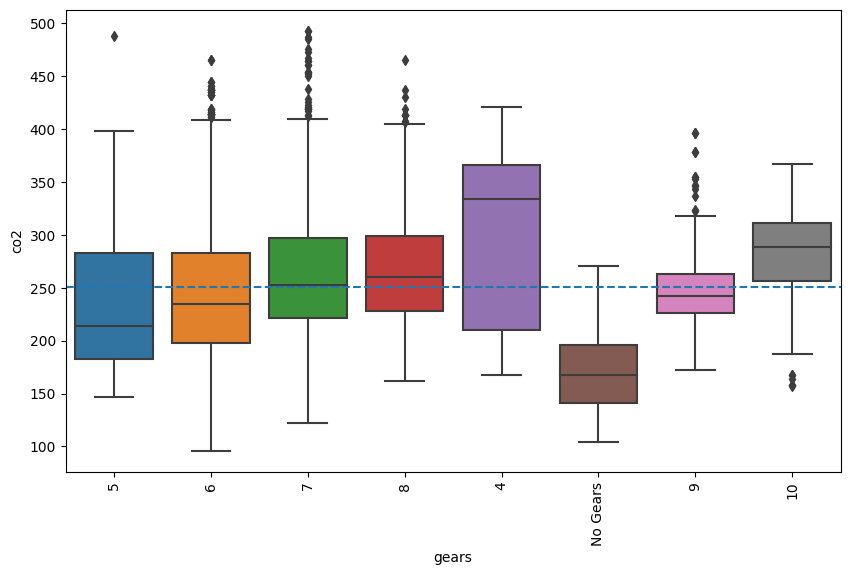

In [38]:
sns.boxplot(data = df, x = "gears", y = "co2")
plt.xticks(rotation = 90)
plt.axhline(y = df.co2.mean(), linestyle = "--") 
plt. show()

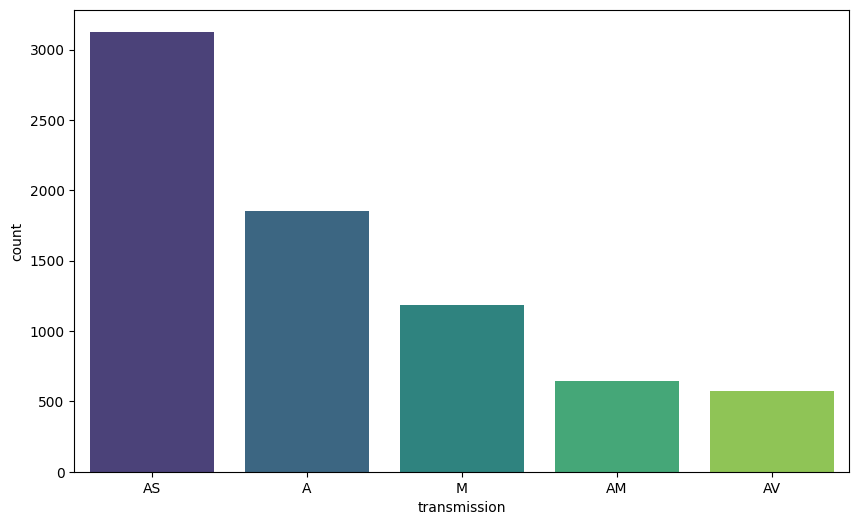

In [39]:
sns.countplot(data = df, x = "transmission", palette = "viridis", order = df.transmission.value_counts().index)
plt.show()

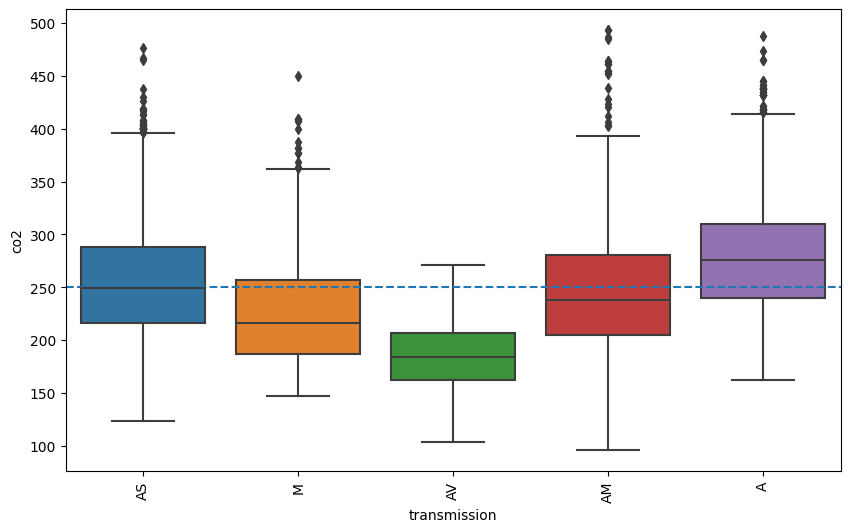

In [40]:
sns.boxplot(data = df, x = "transmission", y = "co2")
plt.xticks(rotation = 90)
plt.axhline(y = df.co2.mean(), linestyle = "--") 
plt. show()

## Fuel

In [41]:
for i in ["fuel_cons_city", "fuel_cons_hwy", "fuel_cons_comb_mpg"]:
    print("fuel_cons_comb corr with", i, " : ",df["fuel_cons_comb"].corr(df[i]))
# aralarında çok yüksek korelasyon var

fuel_cons_comb corr with fuel_cons_city  :  0.9937703709177685
fuel_cons_comb corr with fuel_cons_hwy  :  0.9772104143234117
fuel_cons_comb corr with fuel_cons_comb_mpg  :  -0.9259945179195344


In [42]:
df.head()

make       model vehicle_class  engine_size  cylinders transmission gears   
0  ACURA         ILX       COMPACT          2.0          4           AS     5  \
1  ACURA         ILX       COMPACT          2.4          4            M     6   
2  ACURA  ILX HYBRID       COMPACT          1.5          4           AV     7   
3  ACURA     MDX 4WD   SUV - SMALL          3.5          6           AS     6   
4  ACURA     RDX AWD   SUV - SMALL          3.5          6           AS     6   

  fuel_type  fuel_cons_city  fuel_cons_hwy  fuel_cons_comb   
0         Z             9.9            6.7             8.5  \
1         Z            11.2            7.7             9.6   
2         Z             6.0            5.8             5.9   
3         Z            12.7            9.1            11.1   
4         Z            12.1            8.7            10.6   

   fuel_cons_comb_mpg  co2  
0                  33  196  
1                  29  221  
2                  48  136  
3                  25  255  
4                  27  244

## Fuel Type

In [43]:
df.fuel_type.value_counts()
# N 1 adet olduğu için düşürmek gerekebilir

fuel_type
X    3637
Z    3197
E     370
D     175
N       1
Name: count, dtype: int64

In [44]:
index_ = df[df.fuel_type == "N"].index
df.drop(index_, inplace = True)

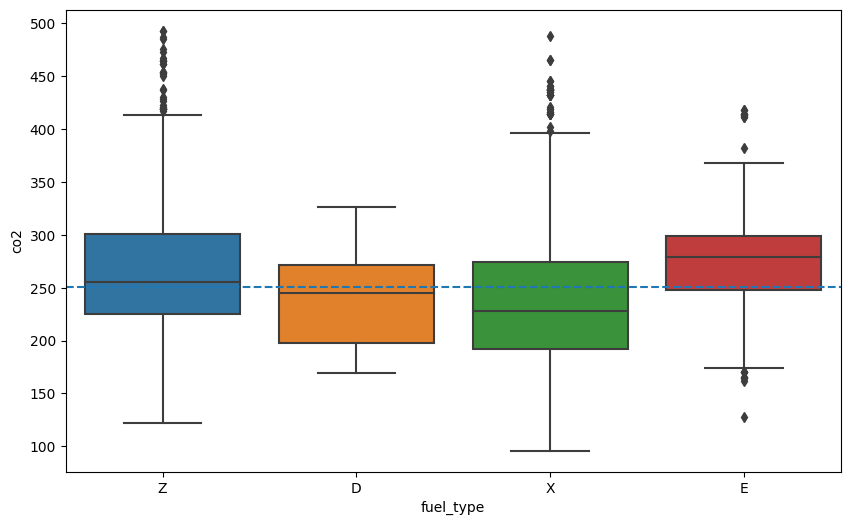

In [45]:
sns.boxplot(data = df, x = "fuel_type", y = "co2")
plt.axhline(y = df.co2.mean(), linestyle = "--") 
plt. show()

# Simple Linear Regression

##  with statsmodel

In [46]:
X = df["engine_size"]
y = df["co2"]

In [47]:
# işlemlerin yapılabilmesi için sabit değer ekliyoruz
X = sm.add_constant(X)

In [48]:
slm = sm.OLS(y, X)
model = slm.fit()

In [49]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                 1.925e+04
Date:                Sat, 15 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:15:50   Log-Likelihood:                -35726.
No. Observations:                7379   AIC:                         7.146e+04
Df Residuals:                    7377   BIC:                         7.147e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         134.5297      0.908    148.094      0.000     132.749     136.310
engine_size    36.7204      0.265    138.752      0.000      36.202      37.239
==============================================================================
Omnibus:                      212.891   Durbin-Watson:                   0.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              533.054
Skew:                           0.070   Prob(JB):                    1.77e-116
Kurtosis:                       4.309   Cond. No.                         9.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
df.co2.corr(df.engine_size) ** 2

0.7229733952692688

## with skitlearn

In [51]:
slr = LinearRegression()
model = slr.fit(X, y)

In [52]:
model.score(X, y)

0.7229733952692686

# Multiple Linear Regression

In [53]:
X = df[["engine_size", "fuel_cons_city", "fuel_cons_comb", "fuel_cons_hwy"]]
y = df["co2"]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1)

In [55]:
model = LinearRegression()

In [56]:
model.fit(X_train, y_train)

LinearRegression()

In [57]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [58]:
ls = train_val(y_train, y_train_pred, y_test, y_test_pred, "linear")
ls

linear_train  linear_test
R2        0.874322     0.864867
mae      13.254711    14.253861
mse     424.569143   467.076639
rmse     20.605076    21.611956

In [59]:
model = LinearRegression()
scores = cross_validate(model, X_train, y_train, 
                        scoring = ["r2", "neg_mean_absolute_error","neg_mean_squared_error",
                                                            "neg_root_mean_squared_error"], cv = 10)
pd.DataFrame(scores, index = range(1, 11))

fit_time  score_time   test_r2  test_neg_mean_absolute_error   
1   0.003022    0.002393  0.858738                    -13.350240  \
2   0.001999    0.001001  0.870484                    -13.214530   
3   0.001993    0.002179  0.881042                    -13.140669   
4   0.003441    0.001015  0.888419                    -12.811098   
5   0.002985    0.001014  0.870764                    -13.759598   
6   0.002588    0.001216  0.878925                    -13.175339   
7   0.002993    0.000998  0.872117                    -13.128064   
8   0.002524    0.001025  0.857473                    -13.672119   
9   0.002022    0.001993  0.895479                    -12.543584   
10  0.001997    0.001010  0.864024                    -13.854888   

    test_neg_mean_squared_error  test_neg_root_mean_squared_error  
1                   -443.270628                        -21.053993  
2                   -433.621692                        -20.823585  
3                   -388.942301                        -19.721620  
4                   -385.582379                        -19.636252  
5                   -461.912669                        -21.492154  
6                   -421.117023                        -20.521136  
7                   -420.648197                        -20.509710  
8                   -468.679446                        -21.649006  
9                   -360.266388                        -18.980685  
10                  -470.626383                        -21.693925

In [60]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:, 2:].mean()

# cv sonuçları ilkel skorlarla uyumlu

test_r2                               0.873747
test_neg_mean_absolute_error        -13.265013
test_neg_mean_squared_error        -425.466711
test_neg_root_mean_squared_error    -20.608206
dtype: float64

## MLR with scaling

In [61]:
scaler = StandardScaler()

In [62]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [63]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [64]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

In [65]:
ls_s = train_val(y_train, y_train_pred, y_test, y_test_pred, "lin_scale")
ls_s

lin_scale_train  lin_scale_test
R2           0.874322        0.864867
mae         13.254711       14.253861
mse        424.569143      467.076639
rmse        20.605076       21.611956

In [66]:
model = LinearRegression()
scores = cross_validate(model, X_train_scaled, y_train, 
                        scoring = ["r2", "neg_mean_absolute_error","neg_mean_squared_error",
                                                            "neg_root_mean_squared_error"], cv = 10)
pd.DataFrame(scores, index = range(1, 11))

fit_time  score_time   test_r2  test_neg_mean_absolute_error   
1   0.002008    0.001004  0.858738                    -13.350240  \
2   0.001996    0.001174  0.870484                    -13.214530   
3   0.001015    0.001014  0.881042                    -13.140669   
4   0.002061    0.000000  0.888419                    -12.811098   
5   0.001004    0.000990  0.870764                    -13.759598   
6   0.000997    0.001011  0.878925                    -13.175339   
7   0.000999    0.001000  0.872117                    -13.128064   
8   0.001536    0.000000  0.857473                    -13.672119   
9   0.001516    0.001040  0.895479                    -12.543584   
10  0.001996    0.000000  0.864024                    -13.854888   

    test_neg_mean_squared_error  test_neg_root_mean_squared_error  
1                   -443.270628                        -21.053993  
2                   -433.621692                        -20.823585  
3                   -388.942301                        -19.721620  
4                   -385.582379                        -19.636252  
5                   -461.912669                        -21.492154  
6                   -421.117023                        -20.521136  
7                   -420.648197                        -20.509710  
8                   -468.679446                        -21.649006  
9                   -360.266388                        -18.980685  
10                  -470.626383                        -21.693925

In [67]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:, 2:].mean()

# cv sonuçları ilkel skorlarla uyumlu

test_r2                               0.873747
test_neg_mean_absolute_error        -13.265013
test_neg_mean_squared_error        -425.466711
test_neg_root_mean_squared_error    -20.608206
dtype: float64

In [68]:
# scale ile bir şey değişmedi
total_result = pd.concat([ls, ls_s], axis = 1)
total_result

linear_train  linear_test  lin_scale_train  lin_scale_test
R2        0.874322     0.864867         0.874322        0.864867
mae      13.254711    14.253861        13.254711       14.253861
mse     424.569143   467.076639       424.569143      467.076639
rmse     20.605076    21.611956        20.605076       21.611956

## with new columns

In [69]:
df.reset_index(inplace = True, drop = True)

In [70]:
enc = OneHotEncoder(drop = "first")
enc_data = enc.fit_transform(df[["fuel_type", "transmission"]]).toarray()
enc_df = pd.DataFrame(enc_data, columns = enc.get_feature_names(["fuel_type", "transmission"]))
enc_df

fuel_type_E  fuel_type_X  fuel_type_Z  transmission_AM  transmission_AS   
0             0.0          0.0          1.0              0.0              1.0  \
1             0.0          0.0          1.0              0.0              0.0   
2             0.0          0.0          1.0              0.0              0.0   
3             0.0          0.0          1.0              0.0              1.0   
4             0.0          0.0          1.0              0.0              1.0   
...           ...          ...          ...              ...              ...   
7374          0.0          0.0          1.0              0.0              1.0   
7375          0.0          0.0          1.0              0.0              1.0   
7376          0.0          0.0          1.0              0.0              1.0   
7377          0.0          0.0          1.0              0.0              1.0   
7378          0.0          0.0          1.0              0.0              1.0   

      transmission_AV  transmission_M  
0                 0.0             0.0  
1                 0.0             1.0  
2                 1.0             0.0  
3                 0.0             0.0  
4                 0.0             0.0  
...               ...             ...  
7374              0.0             0.0  
7375              0.0             0.0  
7376              0.0             0.0  
7377              0.0             0.0  
7378              0.0             0.0  

[7379 rows x 7 columns]

In [71]:
df = pd.concat([df, enc_df], axis = 1)

In [72]:
df.drop(columns = ["make", "model", "vehicle_class", "transmission", "fuel_type"], inplace = True)

In [73]:
df.head()

engine_size  cylinders gears  fuel_cons_city  fuel_cons_hwy   
0          2.0          4     5             9.9            6.7  \
1          2.4          4     6            11.2            7.7   
2          1.5          4     7             6.0            5.8   
3          3.5          6     6            12.7            9.1   
4          3.5          6     6            12.1            8.7   

   fuel_cons_comb  fuel_cons_comb_mpg  co2  fuel_type_E  fuel_type_X   
0             8.5                  33  196          0.0          0.0  \
1             9.6                  29  221          0.0          0.0   
2             5.9                  48  136          0.0          0.0   
3            11.1                  25  255          0.0          0.0   
4            10.6                  27  244          0.0          0.0   

   fuel_type_Z  transmission_AM  transmission_AS  transmission_AV   
0          1.0              0.0              1.0              0.0  \
1          1.0              0.0              0.0              0.0   
2          1.0              0.0              0.0              1.0   
3          1.0              0.0              1.0              0.0   
4          1.0              0.0              1.0              0.0   

   transmission_M  
0             0.0  
1             1.0  
2             0.0  
3             0.0  
4             0.0

In [74]:
X = df.drop(columns = ["gears", "co2"])
y = df["co2"]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 1)

In [76]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [77]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [78]:
lin_new_col = train_val(y_train, y_train_pred, y_test, y_test_pred, "lin_new_columns")
lin_new_col

lin_new_columns_train  lin_new_columns_test
R2                 0.992688              0.993373
mae                3.017491              2.984680
mse               24.702265             22.904745
rmse               4.970137              4.785890

In [79]:
model = LinearRegression()
scores = cross_validate(model, X_train, y_train, 
                        scoring = ["r2", "neg_mean_absolute_error","neg_mean_squared_error",
                                                            "neg_root_mean_squared_error"], cv = 10)
pd.DataFrame(scores, index = range(1, 11))

fit_time  score_time   test_r2  test_neg_mean_absolute_error   
1   0.005157    0.001011  0.993087                     -2.852903  \
2   0.003689    0.001290  0.991461                     -3.023543   
3   0.004000    0.001002  0.993654                     -3.093054   
4   0.003989    0.001001  0.993692                     -2.908766   
5   0.004003    0.001006  0.990708                     -3.257100   
6   0.003927    0.001001  0.989303                     -3.246118   
7   0.003999    0.001002  0.992965                     -3.104658   
8   0.004044    0.001007  0.993937                     -2.834259   
9   0.002998    0.001001  0.994095                     -2.938566   
10  0.003533    0.002020  0.992932                     -3.013747   

    test_neg_mean_squared_error  test_neg_root_mean_squared_error  
1                    -21.692851                         -4.657558  
2                    -28.588539                         -5.346825  
3                    -20.748362                         -4.555037  
4                    -21.796742                         -4.668698  
5                    -33.210163                         -5.762826  
6                    -37.206291                         -6.099696  
7                    -23.140944                         -4.810504  
8                    -19.935811                         -4.464954  
9                    -20.352146                         -4.511335  
10                   -24.463972                         -4.946107

In [81]:
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:, 2:].mean()

# cv sonuçları ilkel skorlarla uyumlu

test_r2                              0.992584
test_neg_mean_absolute_error        -3.027271
test_neg_mean_squared_error        -25.113582
test_neg_root_mean_squared_error    -4.982354
dtype: float64

In [80]:
total_result = pd.concat([total_result, lin_new_col], axis = 1)
total_result

linear_train  linear_test  lin_scale_train  lin_scale_test   
R2        0.874322     0.864867         0.874322        0.864867  \
mae      13.254711    14.253861        13.254711       14.253861   
mse     424.569143   467.076639       424.569143      467.076639   
rmse     20.605076    21.611956        20.605076       21.611956   

      lin_new_columns_train  lin_new_columns_test  
R2                 0.992688              0.993373  
mae                3.017491              2.984680  
mse               24.702265             22.904745  
rmse               4.970137              4.785890

## with Ridge

In [85]:
alpha_space = np.linspace(0.01, 1, 100)

ridge = RidgeCV(alphas = alpha_space, cv = 10, scoring = "neg_root_mean_squared_error")

ridge.fit(X_train, y_train)

RidgeCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
        cv=10, scoring='neg_root_mean_squared_error')

In [87]:
y_pred = ridge.predict(X_test)
y_train_pred = ridge.predict(X_train)

In [88]:
rcs = train_val(y_train, y_train_pred, y_test, y_pred, "ridge_cv")
rcs

ridge_cv_train  ridge_cv_test
R2          0.992688       0.993373
mae         3.017701       2.985024
mse        24.702272      22.905674
rmse        4.970138       4.785987

In [89]:
total_result = pd.concat([total_result, rcs], axis = 1)
total_result

linear_train  linear_test  lin_scale_train  lin_scale_test   
R2        0.874322     0.864867         0.874322        0.864867  \
mae      13.254711    14.253861        13.254711       14.253861   
mse     424.569143   467.076639       424.569143      467.076639   
rmse     20.605076    21.611956        20.605076       21.611956   

      lin_new_columns_train  lin_new_columns_test  ridge_cv_train   
R2                 0.992688              0.993373        0.992688  \
mae                3.017491              2.984680        3.017701   
mse               24.702265             22.904745       24.702272   
rmse               4.970137              4.785890        4.970138   

      ridge_cv_test  
R2         0.993373  
mae        2.985024  
mse       22.905674  
rmse       4.785987

## with Lasso

In [93]:
lasso = LassoCV(alphas = alpha_space, cv = 10, max_iter = 100000, random_state = 1)
lasso.fit(X_train, y_train)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ]),
        cv=10, max_iter=100000, random_state=1)

In [94]:
y_pred = lasso.predict(X_test)
y_train_pred = lasso.predict(X_train)

In [95]:
las = train_val(y_train, y_train_pred, y_test, y_pred, "lasso_cv")
total_result = pd.concat([total_result, las], axis = 1)
total_result

linear_train  linear_test  lin_scale_train  lin_scale_test   
R2        0.874322     0.864867         0.874322        0.864867  \
mae      13.254711    14.253861        13.254711       14.253861   
mse     424.569143   467.076639       424.569143      467.076639   
rmse     20.605076    21.611956        20.605076       21.611956   

      lin_new_columns_train  lin_new_columns_test  ridge_cv_train   
R2                 0.992688              0.993373        0.992688  \
mae                3.017491              2.984680        3.017701   
mse               24.702265             22.904745       24.702272   
rmse               4.970137              4.785890        4.970138   

      ridge_cv_test  lasso_cv_train  lasso_cv_test  
R2         0.993373        0.992631       0.993375  
mae        2.985024        3.026496       2.992988  
mse       22.905674       24.895538      22.899858  
rmse       4.785987        4.989543       4.785380